In [ ]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
x_train = HDF5Matrix('camelyonpatch_level_2_split_train_x.h5', 'x')
y_train = HDF5Matrix('camelyonpatch_level_2_split_train_y.h5', 'y')
x_val=HDF5Matrix('camelyonpatch_level_2_split_valid_x.h5','x')
y_val=HDF5Matrix('camelyonpatch_level_2_split_valid_y.h5','y')
x_test=HDF5Matrix('camelyonpatch_level_2_split_test_x.h5','x')
y_test=HDF5Matrix('camelyonpatch_level_2_split_test_y.h5','y')

Instructions for updating:
Training with HDF5Matrix is not optimized for performance. Instead, we recommend using https://github.com/tensorflow/io to load your HDF5 data into a tf.data Dataset and passing that dataset to Keras.


C:\Users\79892\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\io_utils.py:133: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


In [ ]:
x_train = x_train[:10000]
y_train = y_train[:10000]
x_val=x_val[:3000]
y_val=y_val[:3000]
x_test=x_test[:3000]
y_test=y_test[:3000]

In [ ]:
datagen = ImageDataGenerator(
              preprocessing_function=lambda x: x/255.,
              width_shift_range=4,  # randomly shift images horizontally
              height_shift_range=4,  # randomly shift images vertically
              horizontal_flip=True,  # randomly flip images
              vertical_flip=True)  # randomly flip images

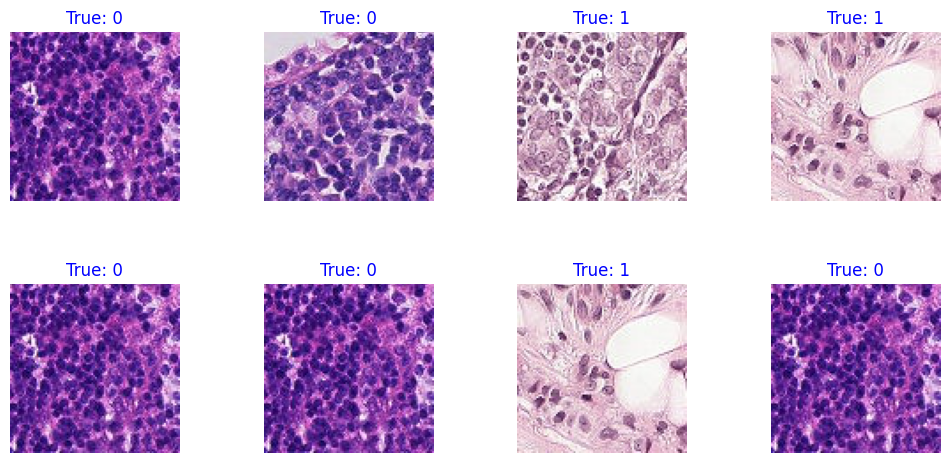

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, predictions=None):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(8):
        index = np.random.randint(0, len(images))
        ax = axes[i]
        ax.imshow(images[index])

        if predictions is not None:
            true_label = labels[index][0][0][0]
            pred_label = predictions[index]
            title = f"True: {true_label}, Pred: {pred_label}"
            title_color = 'green' if true_label == pred_label else 'red'
        else:
            title = f"True: {labels[index][0][0][0]}"
            title_color = 'blue'

        ax.set_title(title, color=title_color, fontsize=12)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.5)

# Get sample images and labels from HDF5Matrix
sample_images = x_train[:8]
sample_labels = y_train[:8]

plot_images(sample_images, sample_labels)
plt.show()


In [ ]:
from keras.layers import Input, Add, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Add, GlobalAveragePooling2D, Activation
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def identity_block(X, filters):
    F1, F2 = filters

    X_shortcut = X

    # First Conv Layer
    X = Conv2D(F1, (3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second Conv Layer
    X = Conv2D(F2, (3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)

    # Add Shortcut and pass through RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, filters, s=2):
    F1, F2 = filters

    X_shortcut = X

    # First Conv Layer
    X = Conv2D(F1, (3, 3), strides=(s, s), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second Conv Layer
    X = Conv2D(F2, (3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)

    # Shortcut Path
    X_shortcut = Conv2D(F2, (1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Add Shortcut and pass through RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X
def build_resnet18(input_shape):
    input_tensor = Input(input_shape)

    # Initial Conv
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Residual Blocks
    X = convolutional_block(X, [64, 64], s=1)
    X = identity_block(X, [64, 64])

    X = convolutional_block(X, [128, 128])
    X = identity_block(X, [128, 128])

    X = convolutional_block(X, [256, 256])
    X = identity_block(X, [256, 256])

    X = convolutional_block(X, [512, 512])
    X = identity_block(X, [512, 512])

    # Average Pooling
    X = GlobalAveragePooling2D()(X)

    # MLP
    X = Dense(2048, activation='relu')(X)
    X = BatchNormalization()(X)
#     X = Dropout(0.5)(X)

    X = Dense(1024, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dense(512, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)

    # Output Layer
    X = Dense(1, activation='sigmoid', name='predictions')(X)

    model = Model(inputs=input_tensor, outputs=X)

    return model


input_shape = (96, 96, 3)
model = build_resnet18(input_shape)

# Optimizer choice
optimizer = Adam(learning_rate=0.001)

# Model Compilation
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

# Preprocessing
train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_data_gen = ImageDataGenerator(rescale=1./255)

# Data generation
train_gen = train_data_gen.flow(x_train, y_train, batch_size=8)
val_gen = val_data_gen.flow(x_val, y_val, batch_size=8)
# Define the leqrning rate
lr_schedule = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.8,
                                patience=10,
                                verbose=1,
                                min_lr=0.00001)

# parameters setting
batch_size = 8
epochs = 150

# Model training
history = model.fit(train_gen,
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=len(x_val) // batch_size,
                    callbacks=[lr_schedule])

Epoch 1/150
1250/1250 [==============================] - 47s 38ms/step - loss: 0.6446 - accuracy: 0.6908 - val_loss: 0.5854 - val_accuracy: 0.7540
Epoch 2/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.5865 - accuracy: 0.7203 - val_loss: 1.1969 - val_accuracy: 0.6407
Epoch 3/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.5698 - accuracy: 0.7240 - val_loss: 0.7786 - val_accuracy: 0.4907
Epoch 4/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.5724 - accuracy: 0.7196 - val_loss: 0.6895 - val_accuracy: 0.5833
Epoch 5/150
1250/1250 [==============================] - 47s 37ms/step - loss: 0.5365 - accuracy: 0.7436 - val_loss: 0.6678 - val_accuracy: 0.6033
Epoch 6/150
1250/1250 [==============================] - 47s 37ms/step - loss: 0.5201 - accuracy: 0.7550 - val_loss: 1.1457 - val_accuracy: 0.4963
Epoch 7/150
1250/1250 [==============================] - 47s 38ms/step - loss: 0.4995 - accuracy: 0.7690 - val_loss: 0

Epoch 54/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3506 - accuracy: 0.8619 - val_loss: 0.4199 - val_accuracy: 0.8100
Epoch 55/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3475 - accuracy: 0.8666 - val_loss: 27.3925 - val_accuracy: 0.8183
Epoch 56/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3473 - accuracy: 0.8679 - val_loss: 0.5004 - val_accuracy: 0.7933
Epoch 57/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3386 - accuracy: 0.8721 - val_loss: 0.5973 - val_accuracy: 0.7623
Epoch 58/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3503 - accuracy: 0.8666 - val_loss: 0.6250 - val_accuracy: 0.7277
Epoch 59/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3516 - accuracy: 0.8666 - val_loss: 0.4665 - val_accuracy: 0.7903
Epoch 60/150
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3639 - accuracy: 0.8585 - val

Epoch 106/150
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2973 - accuracy: 0.8878 - val_loss: 0.4176 - val_accuracy: 0.8213
Epoch 107/150
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2823 - accuracy: 0.8934 - val_loss: 0.4080 - val_accuracy: 0.8300
Epoch 108/150
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2936 - accuracy: 0.8898 - val_loss: 0.4347 - val_accuracy: 0.8157
Epoch 109/150
1249/1250 [============================>.] - ETA: 0s - loss: 0.2849 - accuracy: 0.8938
Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2850 - accuracy: 0.8937 - val_loss: 0.5519 - val_accuracy: 0.7007
Epoch 110/150
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2909 - accuracy: 0.8938 - val_loss: 0.4460 - val_accuracy: 0.8133
Epoch 111/150
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2850

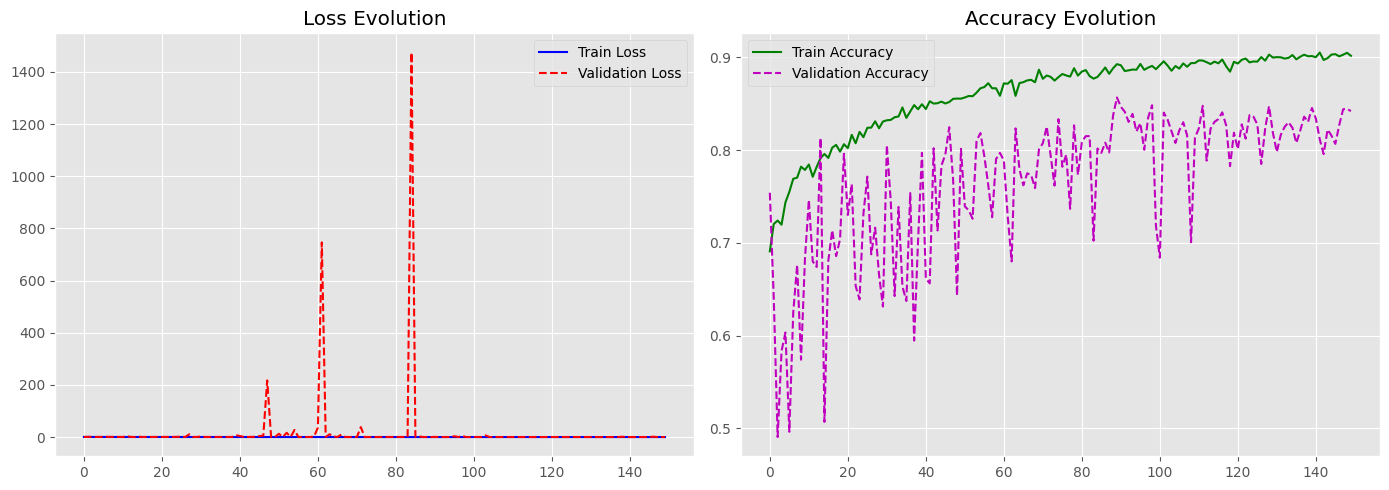

In [ ]:
plt.style.use('ggplot')

# Plot the trainging set and validation set loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linestyle='-', color='b')  # (in blue)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color='r')  # (in red dotted)
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='-', color='g')  # (in green)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='m')  # (in rose dotted)
plt.title('Accuracy Evolution')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_performance(model, x_test, y_test, batch_size):

    test_gen = ImageDataGenerator(preprocessing_function=lambda x: x/255.).flow(x_test, y_test, batch_size=batch_size, shuffle=False)


    test_loss, test_accuracy = model.evaluate(test_gen, steps=len(x_test) // batch_size)

    # result
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")

evaluate_performance(model, x_test[100:200], y_test[100:200], batch_size)

12/12 [==============================] - 0s 8ms/step - loss: 0.3398 - accuracy: 0.8750
Test Loss: 0.3398
Test Accuracy: 87.50%
